In [182]:
# !pip install timm
# !pip install captum

In [183]:
import torch
import timm
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import Resize
from captum.attr import LayerGradCam, GuidedGradCam
from torchvision.transforms.functional import to_pil_image

In [184]:
model = timm.create_model("tiny_vit_5m_224", pretrained=False, num_classes=37)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dict = torch.load(
    "tinyvit_trained_model.pth", map_location=torch.device("cpu"), weights_only=True
)
print("About to load state dict...")
try:
    model.load_state_dict(state_dict)
    print("State dict loaded successfully!")
except Exception as e:
    print(f"Error while loading state dict: {e}")

model = model.to(device)
_ = model.eval()

About to load state dict...
State dict loaded successfully!


In [185]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize all images to 224x224
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
    ]
)

image = Image.open("cat.jpeg")
input_tensor = transform(image).unsqueeze(0)

In [186]:
target_layer = model.stages[-1].blocks[-1].local_conv.conv # last conv layer

In [187]:
def min_max_scale(image):
    min_val = image.min()
    max_val = image.max()
    scaled_image = (image - min_val) / (max_val - min_val)

    return scaled_image

In [188]:
def compute_guided_cam(original_image, image, predicted_class):
    cam = GuidedGradCam(model, target_layer)
    _ = model(image)

    cam_map = cam.attribute(input_tensor, predicted_class)
    guided_grad_cam_map = min_max_scale(cam_map.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

    return guided_grad_cam_map

In [189]:
def compute_layer_cam(original_image, image, predicted_class):
    cam = LayerGradCam(model, target_layer)
    _ = model(image)

    cam_map = cam.attribute(input_tensor, predicted_class)
    layer_grad_cam_map = min_max_scale(cam_map.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

    return layer_grad_cam_map

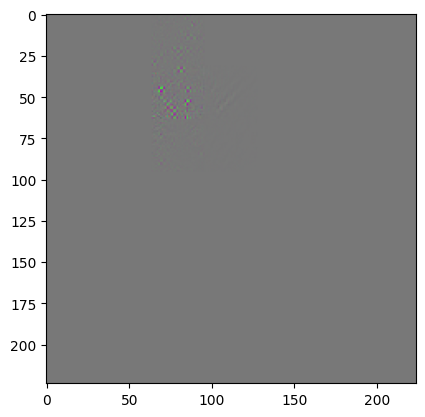

In [190]:
image = torchvision.io.read_image("cat.jpeg")
original_image_pil = to_pil_image(Resize((224, 224)).forward(image))
predicted_class = int(np.argmax(model(input_tensor).cpu().detach().numpy()))
guided_cam_map = compute_guided_cam(original_image_pil, input_tensor, predicted_class)
plt.imshow(guided_cam_map)

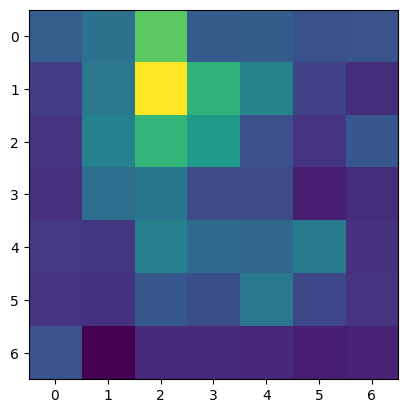

In [191]:
layer_cam_map = compute_layer_cam(original_image_pil, input_tensor, predicted_class)
plt.imshow(layer_cam_map)